# Ns-3 Replay.

You use this notebook to explore the ns-3 replay results and/or recreate Figure 8 (a--c) in the paper.

## Prerequisites

You must download and evaluate the puffer data, which you can do by running the following CLI commands:

```bash
./run.py ns3-replay
```

On 20 CPU Cores, each individual experiment takes between 1 to 2 hours to run.
On a GPU, you can typically expect less than an hour per experiment.

This will use the simulation data in [ns3-simulation/results](../ns3-simulation/results).
If you want to regenerate the simulation data or simulate different scenarios, follow the instructions in [ns3-simulation/README.md](../ns3-simulation/README.md).

## Imports and Settings

In [1]:
import sys
sys.path.append('..')  # To allow imports from parent directory
%load_ext autoreload
%autoreload 2

In [2]:
import experiment_helpers as eh
import pandas as pd
import seaborn as sns
from experiment_helpers.data import Path
from matplotlib import pyplot as plt  # ticker

# Load the config, including the local config.
from config import Config as LocalConfig  # Load from file: ../config.py
from experiments.ns3.config import Ns3ExperimentConfig
from experiments.ns3.implementation.load_data import load_frame

config = Ns3ExperimentConfig.with_updates(LocalConfig)
resultdir = Path(config.output_directory) / 'ns3-replay'

In [3]:
# Plot import and color settings
%matplotlib inline

# Set theme and parameters
eh.plot_utils.setup(latex=True)

def plot_markers(*markers, offset=3):
    """Helper to annotate plot phases."""
    ax = plt.gca()
    ylim = ax.get_ylim()
    for x, text in markers:
        ax.plot([x, x], ylim, color='black', zorder=1, linewidth=1)
        ax.annotate(text, xy=(x, ylim[1]),
                    va='bottom', ha='left',
                    xytext=(offset, offset),
                    textcoords="offset points")
    ax.set_ylim(ylim)  # Counteract auto-adjustment.

base_palette = sns.color_palette("deep")
palette = {
    "Memento": base_palette[0],
    "Random": base_palette[1],
    "Memento(T=0)": base_palette[4],
    "FIFO": base_palette[2],
    "LARS": base_palette[3],
}


plotdir = Path("../plots/ns3")
plotdir.mkdir(exist_ok=True, parents=True)

# Data Overview

Show the average number of samples per ns3 simulation run.

In [4]:
statframe = eh.data.read_csv(resultdir / 'overview/overview.csv.gz')
statframe.groupby("experiment").min().astype(int)

,run,horizon,wl_samples,tt_samples
experiment,,,,
skewed1,0,128,52991,52991
skewed3,0,128,51469,51469
w1,0,128,10082,10082
w1_c100,0,128,10082,10082
w1_c133,0,128,10120,10120
w1w2,0,128,85302,85302
w1w3,0,128,6042,6042
w2,0,128,165718,165718
w2_c100,0,128,99818,99818


The data is skewed heavily towards w2. w1 and w3 make up a small fraction of total packets.
Let's compute the exact fractions for the periodic experiment, where w2 is present all the time and w1 and w3 only appear sporadically.

In [5]:
total = (
    statframe
    .query("experiment == 'w2'")
    [lambda df: df['run'].isin(range(2,23))]
    ['wl_samples'].sum()
)

w1 = (
    statframe
    .query("experiment == 'w1'")
    [lambda df: df['run'].isin(range(2,23, 5))]
    ['wl_samples'].sum()
)
w3 = (
    statframe
    .query("experiment == 'w3'")
    [lambda df: df['run'].isin(range(2,23, 10))]
    ['wl_samples'].sum()
)


w1/total, w3/total

(0.012987468649322886, 0.004674763206681801)

## Packet size distributions 

Looking at the packet size distribution, we can see that w1 and w3 have a much larger fraction of max-MTU-sized packets, while w2 contains smaller packets, which also explains why w2 has so many more packets overall.

Going by packet sizes, this makes w2 easily distinguishable from w1 and w3, which are very similar to each other and more difficult to keep apart.

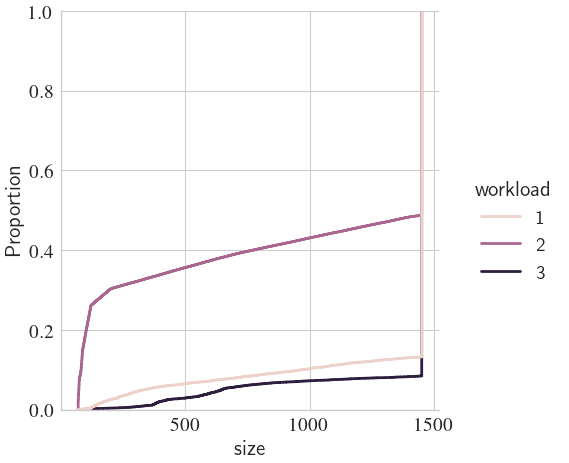

In [6]:
datadir = Path("ssh://fischer/home/alex/memento/data/ns3/")

dist_frames = pd.concat([
    load_frame(datadir / "w1_0.csv"),
    load_frame(datadir / "w2_0.csv"),
    load_frame(datadir / "w3_0.csv")
], ignore_index=True)

sns.displot(
    # +1 to have 1-based workloads index.
    data=dist_frames.assign(workload = lambda df: df['workload'] + 1),
    kind="ecdf",
    x="size",
    hue="workload",
).set(
    #ylim=(0, 0.2),  # To zoom in on w1/w3.
);

# Data Loading

Functions to load results and merge them into a single frame.
We save many more metrics than we visualize here. To help with plotting the metrics we care about, the helper includes arguments to fetch the required metrics.

For aggregate accuracy, consider performance only on classes seen so far.

In [7]:
evaluation_resultdir = resultdir

def load_workload_results(experiments: dict,
                          resultdir=evaluation_resultdir,
                          aggregate=True):
    frames = []
    for label, filename in experiments.items():
        frame = eh.data.read_csv(resultdir / filename / 'results.csv.gz')

        if aggregate: # Compute balanced accuracy on classes observed until now.
            frame = (
                frame
                #.loc[lambda df: df['observed']]
                #.drop(columns=['observed', 'observed_now'])
                .groupby("iteration", as_index=False)
                .mean()
            )

        frames.append(
            frame
            .assign(experiment=label, iteration=lambda df: df['iteration'] + 1)
        )

    return pd.concat(frames, ignore_index=True)

def load_transtime_results(experiments: dict,
                           metric=0.99, experiment='all',
                           resultdir=evaluation_resultdir):
    frames = []
    for label, filename in experiments.items():
        frame = eh.data.read_csv(resultdir / filename / 'results.csv.gz')
        frames.append(
            frame
            [(frame['metric'] == metric)  &
             (frame['experiment'] == experiment)]
            .assign(
                experiment=label,
                iteration=lambda df: df['iteration'] + 1,
                value=lambda df: df['value'] * 1000, # s -> ms
            )
        )

    return pd.concat(frames, ignore_index=True)

def load_stats(experiments: dict,
                        resultdir=evaluation_resultdir):
    frames = []
    for label, filename in experiments.items():
        frame = eh.data.read_csv(resultdir / filename / "stats.csv.gz" )
        frames.append(
            frame
            .assign(experiment=label, iteration=lambda df: df['iteration'] + 1)
        )

    return pd.concat(frames, ignore_index=True)

# Figure 8a: Periodic Patterns

/tmp/ipykernel_6105/1076462417.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()
/tmp/ipykernel_6105/1076462417.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()
/tmp/ipykernel_6105/1076462417.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()
/tmp/ipykernel_6105/1076462417.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future versio

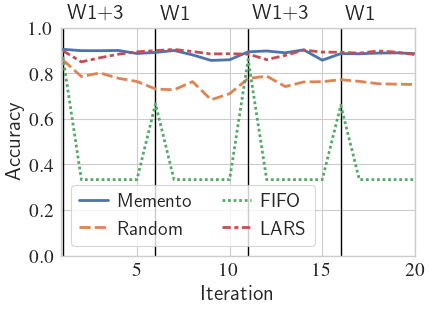

In [8]:
periodic_markers = [(1, "W1+3"), (6, "W1"), (11, "W1+3"), (16, "W1")]
frame = (
    load_workload_results({
        "Memento": "periodic/memento",
        #"Memento(T=0)": "periodic/memento-deterministic",
        "Random": "periodic/random",
        "FIFO": "periodic/fifo",
        "LARS": "periodic/lars",
    })
    .rename(columns={'experiment': "Memory"})
)
sns.relplot(
    data=frame,
    x='iteration',
    y='accuracy',
    hue='Memory',
    style="Memory",
    kind='line',
    palette=palette,
    **eh.plot_utils.opts_onethird()
).set(
    xlabel="Iteration",
    ylabel="Accuracy",
    ylim=(0, 1.0),
    xlim=(0.9, frame['iteration'].max()),
)
#plt.gca().get_legend()._set_loc(3)
plt.legend(
    title=None, loc="lower left",
    ncol=2, columnspacing=1.5, handletextpad=0.5, handlelength=1.5,
)

plot_markers(*periodic_markers)
plt.savefig(plotdir / "periodic_peformance.pdf")
plt.show()

# Figure 8b: Incremental Learning

/tmp/ipykernel_6105/1076462417.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()
/tmp/ipykernel_6105/1076462417.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()
/tmp/ipykernel_6105/1076462417.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()
/tmp/ipykernel_6105/1076462417.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future versio

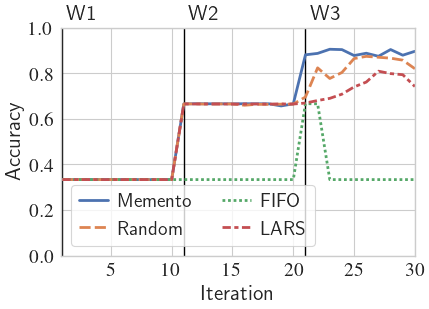

In [9]:
incremental_markers = [(1, "W1"), (11, "W2"), (21, "W3"),]
frame = (
    load_workload_results({
        "Memento": "incremental/memento",
        "Random": "incremental/random",
        #"Memento(T=0)": "incremental/memento-deterministic",
        "FIFO": "incremental/fifo",
        "LARS": "incremental/lars",
    })
    .rename(columns={'experiment': "Memory"})
)
sns.relplot(
    data=frame,
    x='iteration',
    y='accuracy',
    hue='Memory',
    style="Memory",
    kind='line',
    palette=palette,
    #estimator=np.min,
    errorbar=None,  # Not useful for max three entries per iteration.
    **eh.plot_utils.opts_onethird()
).set(
    xlabel="Iteration",
    ylabel="Accuracy",
    ylim=(0, 1.0),
    xlim=(0.9, frame['iteration'].max()),
)
plt.legend(
    title=None, loc="lower left",
    ncol=2, columnspacing=1.5, handletextpad=0.5, handlelength=1.5,
)
plot_markers(*incremental_markers)
plt.savefig(plotdir / "sequential_peformance.pdf")
plt.show()

Some additional insights into how the algorithms pick up new samples:
- as soon as w2 appears, Memento selects enough samples such that there is roughly a 50:50 split between w1 and w2 in the memroy.
- as soon as w3 appears, Memento selects samples such that about 45% of Memory are covered by w3. It removes more samples from w2 than from w1 to make space.

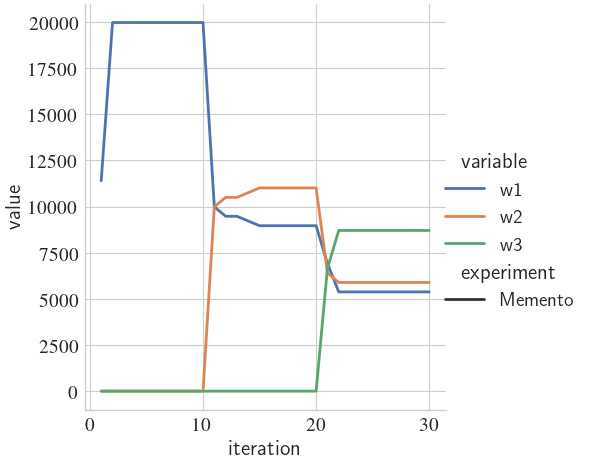

In [10]:
sns.relplot(
    data=load_stats({
        "Memento": "incremental/memento",
    }).melt(id_vars=['iteration', 'experiment'], value_vars=["w1", "w2", "w3"]),
    kind="line",
    x='iteration',
    y='value',
    hue='variable',
    style='experiment',
);

In terms of samples, Memento does not go for an even split. Yet, the select data allows to learn all workloads well.
To gain more insight into Memento's decision, let's look at the estimated coverage of samples space.

Memento does not base it's decision on the sample count, but sample _density_.
Memento reports changes in the space covered by the selected samples by ntegrating (approximately) over the estimated sample space density.
Below we can see the following:
- After w2, Memento reports an increase of 50%
- After w3, an increase of 33%

Note that the increase is computed with respect to the sample space _after_ the update; an increase of 50% means that 50% of the sample space was not covered before.
As soon as w2 appears, Memento discoveres that the sample space is twice as big as it knew before, and selects samples such that both the areas of w1 and w2 are equally covered.

Similarly, as soon as w3 appears, Memento learns that there is a third of the sample space (the area of w3) that it did not know about before, and selects just enough samples to fill it. It appears that more than 33% of samples are needed to cover this 33% of sample space, maybe because samples of w3 are more diverse?


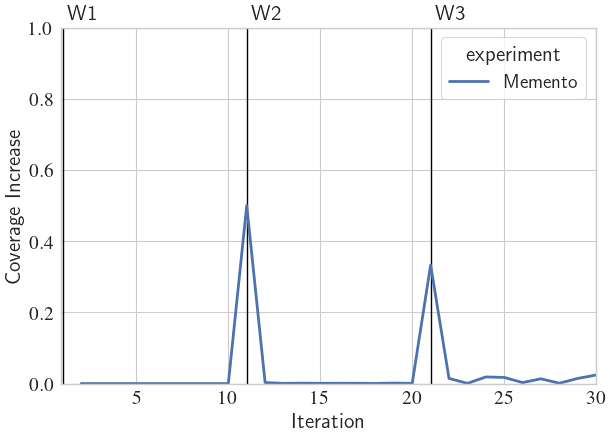

In [11]:
sns.relplot(
    data=load_stats({
        "Memento": "incremental/memento",
    }),
    kind="line",
    x='iteration',
    y='coverage_increase',
    hue='experiment',
    style='experiment',
    **eh.plot_utils.default_opts
).set(
    xlabel="Iteration",
    ylabel="Coverage Increase",
    ylim=(0, 1.0),
    xlim=(0.9, frame['iteration'].max()),
);
# fig = plt.gcf()
# fig.suptitle(
#     "Density increase for incremental learning."
# )
# fig.subplots_adjust(top=0.9)
plot_markers(*incremental_markers);

# Memory overview

At the end of both experiments, how many samples of each workload has Memento ultimately selected?

It manages to preseve rare or past patterns better than the alternatives.

In [12]:
def mem_contents(experiments):
    return (
        load_stats(experiments)
        .loc[
            lambda df: df['iteration'] == df['iteration'].max(),
            ['experiment', 'w1', 'w2', 'w3']
        ]
        # Make pretty!
        .set_index("experiment")
        .rename_axis(index=None)
        .rename(columns={'w1': "W1", 'w2': "W2", 'w3': "W3"})
    )

mem_periodic = mem_contents({
    "Memento": "periodic/memento",
    #"Memento(T=0)": "periodic/memento-deterministic",
    "Random": "periodic/random",
    "LARS": "periodic/lars",
    "FIFO": "periodic/fifo",
})
mem_incremental = mem_contents({
    "Memento": "incremental/memento",
    #"Memento(T=0)": "incremental/memento-deterministic",
    "Random": "incremental/random",
    "LARS": "incremental/lars",
    "FIFO": "incremental/fifo",
})

# Stitch both together in a nice latex table.
# Also add some intermediate headers.
header_periodic = r"\textit{Rare Patterns} (\cref{ssec:sim_tail_perf})\\"
latex_periodic = (
    mem_periodic
    .to_latex()
    .replace("\midrule", f"\midrule\n{header_periodic}")
)
header_incremental = \
    r"\textit{Incremental Learning} (\cref{ssec:sim_no_forgetting})\\"
latex_incremental = (
    mem_incremental
    .to_latex()
    .replace("\midrule", f"\midrule\n{header_incremental}")
)
latex_combined = (
    latex_periodic.split(r'\bottomrule')[0] + # cut off end
    '\midrule' + latex_incremental.split('\midrule')[1] # cut off head
)

print(latex_combined)
with open(plotdir / "final_mem.tex", "w") as file:
    file.write(latex_combined)

\begin{tabular}{lrrr}
\toprule
{} &    W1 &     W2 &    W3 \\
\midrule
\textit{Rare Patterns} (\cref{ssec:sim_tail_perf})\\
Memento &  5696 &   9053 &  5219 \\
Random  &   252 &  19634 &   114 \\
LARS    &  3159 &  14231 &  2610 \\
FIFO    &     0 &  20000 &     0 \\
\midrule
\textit{Incremental Learning} (\cref{ssec:sim_no_forgetting})\\
Memento &  5376 &   5888 &   8704 \\
Random  &  1266 &  17836 &    898 \\
LARS    &  9540 &   9557 &    903 \\
FIFO    &     0 &      0 &  20000 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_6105/1956666400.py:34: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  .to_latex()
/tmp/ipykernel_6105/1956666400.py:41: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  .to_latex()


# Figure 8c: Regression

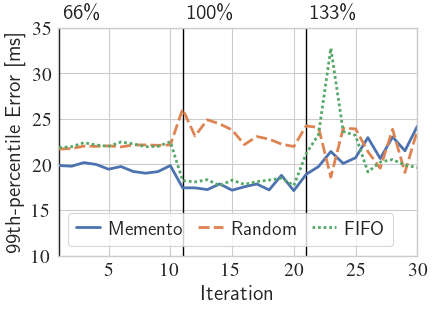

In [13]:
congestion_markers = [
    (1, "66\%"), (11, "100\%"), (21, "133\%"), 
]
frame = (
    load_transtime_results({
        "Memento": "congestion/memento",
        #"Memento(T=0)": "congestion/memento-deterministic",
        "Random": "congestion/random",
        "FIFO": "congestion/fifo",
    }, metric='0.99', experiment="all")
    .rename(columns={'experiment': "Memory"})
)
sns.relplot(
    data=frame,
    x='iteration',
    y='value',
    hue='Memory',
    style="Memory",
    kind='line',
    palette=palette,
    #drawstyle='steps-post',
    #estimator=lambda x: np.quantile(x, 0.99),
    errorbar=None,  # Does not work with steps.
    **eh.plot_utils.opts_onethird()
).set(
    xlabel="Iteration",
    ylabel="99th-percentile Error [ms]",
    #yscale='log',
    ylim=(10, 35),
    xlim=(0.9, frame['iteration'].max()),
)
plt.legend(
    title=None, ncol=3, loc="lower left",
    columnspacing=0.75, handletextpad=0.45, handlelength=1.25
)
plot_markers(*congestion_markers)
plt.savefig(plotdir / "congestion_performance.pdf")
plt.show()